In [ ]:
import sys
# !{sys.executable} -m pip install tldextract

<div style='text-align:center;'>
<h1>S3D Tutorial @ GESIS</h1>
    <h2>Prediction Task on Boston House Pricing</h2>
</div>

In [1]:
__author__ = "Lisette Espin-Noboa"
__copyright__ = "Copyright 2018, S3D Tutorial, GESIS"
__credits__ = ["Peter G Fennell", "Zhiya Zuo", "Kristina Lerman"]
__reference__ = "https://arxiv.org/abs/1810.09841"
__license__ = "GPL"
__version__ = "1.0.3"
__maintainer__ = "Lisette Espin-Noboa"
__email__ = "Lisette.Espin@gesis.org"
__status__ = "Developing"

########################################################################
# Warnings
########################################################################
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

<h2>Dependences</h2>

In [2]:
%reload_ext autoreload
%autoreload 

########################################################################
# System
########################################################################
import os
import palettable
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.colors as mc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

########################################################################
# Local
########################################################################
from s3d import utils
from s3d.pys3d import PYS3D
from split_data import DataSplitter

<h2>Constants</h2>

In [3]:
TRAIN_DATA_FN = 'data/boston_train.csv'
TEST_DATA_FN = 'data/boston_test.csv'
COMPRESSION = None
INDEX_COL = 'ID'
TARGET_COL = 'medv'
TOPK = 5
NUMFOLDS = 3

<h2>Dataset</h2>
<p><div style='font-weight:bold;'>Source:</div><a href='https://www.kaggle.com/c/boston-housing/data'>Kaggle: Boston Housing</a></p>

In [4]:
train_df = pd.read_csv(TRAIN_DATA_FN, compression=COMPRESSION, index_col=INDEX_COL)
train_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
ID,,,,,,,,,,,,,,
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


In [5]:
train_df.dtypes

crim       float64
zn         float64
indus      float64
chas         int64
nox        float64
rm         float64
age        float64
dis        float64
rad          int64
tax          int64
ptratio    float64
black      float64
lstat      float64
medv       float64
dtype: object

In [6]:
train_df.shape

(333, 14)

<h2>Preprocessing data</h2>
<h3>1. Missing numerical values</h3>

In [7]:
### Replacing nan for median values
medians = {}
for i,r in train_df.select_dtypes(exclude=['object']).isna().any().reset_index().iterrows():
    if r[0]:
        c = r.iloc[0]
        medians[c] = train_df[c].median()
train_df.fillna(medians,inplace=True)
train_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
ID,,,,,,,,,,,,,,
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


<h3>2. Missing categorical values</h3>

In [8]:
### Replacing nan for 'undefined'
empty = {}
for i,r in train_df.select_dtypes(include=['object']).isna().any().reset_index().iterrows():
    if r[0]:
        c = r.iloc[0]
        empty[c] = 'undefined'
train_df.fillna(empty,inplace=True)
train_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
ID,,,,,,,,,,,,,,
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


<h3>3. Encoding categorical values</h3>

In [9]:
original_columns = train_df.select_dtypes(include=['object']).columns
for col in original_columns:
    lb = LabelBinarizer()
    lb_results = lb.fit_transform(train_df[col])
    columns = ['{}_code'.format(col)] if len(lb.classes_) == 2 else [ '{}_{}'.format(col,c) for c in lb.classes_]
    tmp = pd.DataFrame(lb_results, columns=columns, index=train_df.index)    
    train_df = pd.concat([train_df,tmp], axis=1)
train_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
ID,,,,,,,,,,,,,,
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


In [10]:
### Only numerical and encoded columns
train_df = train_df[list(set(train_df.columns)-set(original_columns))].copy()
train_df.head()

,crim,chas,zn,nox,indus,black,rad,ptratio,age,lstat,medv,dis,tax,rm
ID,,,,,,,,,,,,,,
1,0.00632,0,18.0,0.538,2.31,396.90,1,15.3,65.2,4.98,24.0,4.0900,296,6.575
2,0.02731,0,0.0,0.469,7.07,396.90,2,17.8,78.9,9.14,21.6,4.9671,242,6.421
4,0.03237,0,0.0,0.458,2.18,394.63,3,18.7,45.8,2.94,33.4,6.0622,222,6.998
5,0.06905,0,0.0,0.458,2.18,396.90,3,18.7,54.2,5.33,36.2,6.0622,222,7.147
7,0.08829,0,12.5,0.524,7.87,395.60,5,15.2,66.6,12.43,22.9,5.5605,311,6.012


<h3>4. Renaming target columns</h3>

In [11]:
try:
    target_column = TARGET_COL
    train_df.rename(columns={target_column:'target'}, inplace=True)
    
    columns = ['target']
    columns.extend(list(set(train_df.columns) - set(['target'])))
    columns = list(columns)    
    train_df = train_df[columns].copy()
    
    data_path = TRAIN_DATA_FN.replace('train','train_ready')
    
    
    train_df.to_csv(data_path, compression=COMPRESSION, index=False)
    print('renaming column {} to target, done!'.format(target_column))
    print('new file: {}'.format(data_path))
except Exception as ex:
    print(ex)

renaming column medv to target, done!
new file: data/boston_train_ready.csv


In [12]:
train_df.head()

,target,crim,chas,zn,nox,indus,black,rad,ptratio,lstat,rm,dis,tax,age
ID,,,,,,,,,,,,,,
1,24.0,0.00632,0,18.0,0.538,2.31,396.90,1,15.3,4.98,6.575,4.0900,296,65.2
2,21.6,0.02731,0,0.0,0.469,7.07,396.90,2,17.8,9.14,6.421,4.9671,242,78.9
4,33.4,0.03237,0,0.0,0.458,2.18,394.63,3,18.7,2.94,6.998,6.0622,222,45.8
5,36.2,0.06905,0,0.0,0.458,2.18,396.90,3,18.7,5.33,7.147,6.0622,222,54.2
7,22.9,0.08829,0,12.5,0.524,7.87,395.60,5,15.2,12.43,6.012,5.5605,311,66.6


<h2>S3D</h2>
<h3>1. Splitting training data</h3>

In [13]:
data_name = 'housepricesBOSTON'
classification_flag = False
standardize_flag = True

ds = DataSplitter(data_path, 
                  data_name,
                  classification_flag,
                  standardize_flag)

num_folds = NUMFOLDS
num_jobs = num_folds
ds.split_data(num_folds, num_jobs)

standardize values
splitting housepricesBOSTON data (333 rows) into 3 folds
using 3 cores
working on fold 0 fold 0 (elapsed time: 0.07 seconds)
working on fold 1 fold 1 (elapsed time: 0.08 seconds)
working on fold 2 fold 2 (elapsed time: 0.08 seconds)


<h3>2. Initialize model</h3>

In [14]:
s3d = PYS3D(data_name, classification_flag=classification_flag)

...s3d initializing...
s3d with housepricesBOSTON data, splitted into 3 folds
data will be loaded from splitted_data/housepricesBOSTON/
built models will be saved to models/housepricesBOSTON/
predictions will be saved to predictions/housepricesBOSTON/
temporary subfolders in  tmp/housepricesBOSTON
...done initializing...



<h3>3. Hyperparameter tunning</h3>

<h4>3.1 Cross validation</h4>

In [15]:
lambda_list = [0.01, 0.03, 0.05, 0.001, 0.003, 0.0001, 0.0003, 0.00001, 0.00003]
num_features = TOPK
num_jobs = len(lambda_list)

s3d.cross_val_multicore(lambda_list, 
                        num_features, 
                        num_cores=num_jobs,
                        calc_threshold=False)


--- cross validation (9 cores) on housepricesBOSTON data ---


/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:137: UserWarning: 5 features requested by only 3 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:222: UserWarning: 5 features requested by only 3 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:137: UserWarning: 5 features requested by only 4 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:137: UserWarning: 5 features requested by only 4 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:222: UserWarning: 5 features requested by only 4 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:222: UserWarning: 5 features requested by only 4 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:137: UserWarning: 5 features requested by only 4 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:222: UserWarning: 5 features requested by only 4 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:13

/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:222: UserWarning: 5 features requested by only 2 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:137: UserWarning: 5 features requested by only 2 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:222: UserWarning: 5 features requested by only 2 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:137: UserWarning: 5 features requested by only 2 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:222: UserWarning: 5 features requested by only 2 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:137: UserWarning: 5 features requested by only 2 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:222: UserWarning: 5 features requested by only 2 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:137: UserWarning: 5 features requested by only 2 selected
  UserWarning)
/bigdata/lespin/S3D/S3D_Tutorial/s3d/pys3d.py:22

--- done multi-core cv; total elapsed time 10.71 seconds


<h4>3.1 Evaluation best hyperparameters</h4>

In [16]:
metric = 'mae'
metric_name = 'Mean Absolute Error'
eval_df = s3d.evaluate(num_jobs=num_jobs, cv_metric=metric)
dimensions = eval_df.num_features.values
eval_df

evaluating s3d model using 9 cores...
command: ./s3d/train -infile:splitted_data/housepricesBOSTON/0/train.csv -outfolder:models/housepricesBOSTON/0/ -lambda:0.01 -ycol:0 -start_skip_rows:-1 -end_skip_rows:-1 -max_features:1
command: ./s3d/train -infile:splitted_data/housepricesBOSTON/1/train.csv -outfolder:models/housepricesBOSTON/1/ -lambda:0.05 -ycol:0 -start_skip_rows:-1 -end_skip_rows:-1 -max_features:3
command: ./s3d/train -infile:splitted_data/housepricesBOSTON/2/train.csv -outfolder:models/housepricesBOSTON/2/ -lambda:0.05 -ycol:0 -start_skip_rows:-1 -end_skip_rows:-1 -max_features:2


,num_features,mae,mae_median,mse,r2,lambda_,split_version
0,1,-0.755006,-0.457453,-1.175565,-0.061201,0.01,0.0
1,3,-0.387538,-0.227857,-0.408324,0.406247,0.05,1.0
2,2,-0.481426,-0.269168,-0.602783,0.513641,0.05,2.0


In [17]:
utils.find_best_param('cv/{}/performance.csv'.format(data_name), metric)

,split_version,lambda_,num_features,best_value,metric
0,0,0.01,1,-0.503622,mae
1,1,0.05,3,-0.491347,mae
2,2,0.05,2,-0.489812,mae


<h3>5. Visualization</h3>

<h4>5.1. Lambda selection</h4>

/ssd/lespin/virtualenv/python3.5/lib/python3.5/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/ssd/lespin/virtualenv/python3.5/lib/python3.5/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/ssd/lespin/virtualenv/python3.5/lib/python3.5/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/ssd/lespin/virtualenv/python3.5/lib/python3.5/site-packages/seaborn/categorical

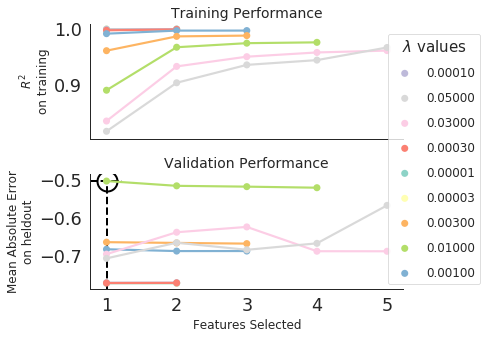

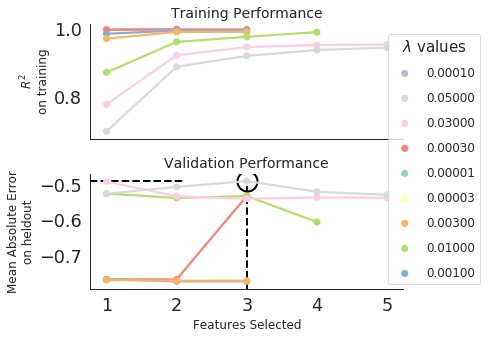

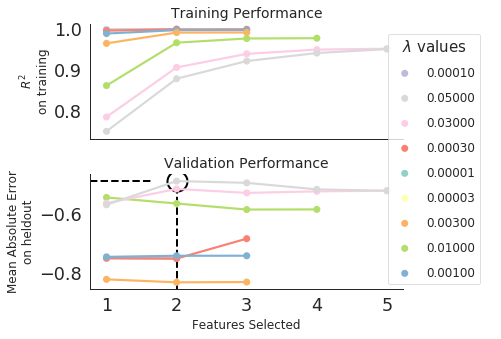

In [18]:
legend_kwargs = {'ncol': 1, 'loc': 7, 'labelspacing': 1,
                 'title': r'$\lambda$ values',
                 'prop': {'size': 12},
                 'bbox_to_anchor': (1, .5),
                }
with sns.axes_style('white'):    
    for num_fold in range(num_folds):
        fp, best_n_f, best_val, best_lambda_, split_version = utils.visualize_cv('cv/{}/performance.csv'.format(data_name), 
                                                                         validation_metric=metric,
                                                                         metric_name=metric_name,
                                                                         legend_kwargs=legend_kwargs,
                                                                         split_version=num_fold, 
                                                                         color_list=palettable.colorbrewer.qualitative.Set3_12.mpl_colors)

<h4>5.2. Feature importance</h4>

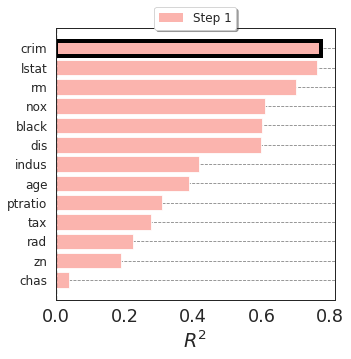

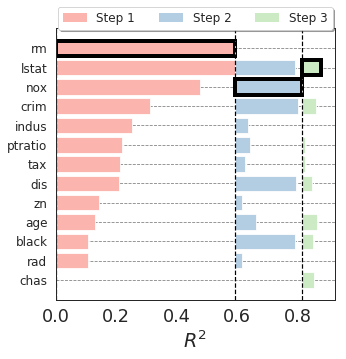

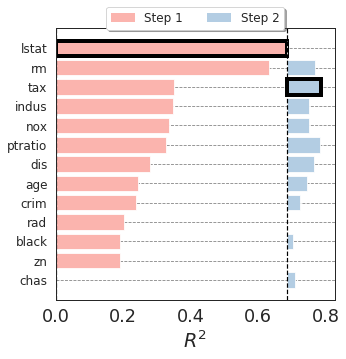

In [19]:
with sns.axes_style('white'):
    for num_fold in range(num_folds):
        train_model = 'models/{}/{}/'.format(data_name,num_fold)
        fig, ax = utils.visualize_s3d_steps(train_model, figsize=(5,5))    
        _ = ax.set_yticklabels(ax.get_yticklabels(),fontdict={'size':12}) 

<h4>5.3. Redundancy between features</h4>

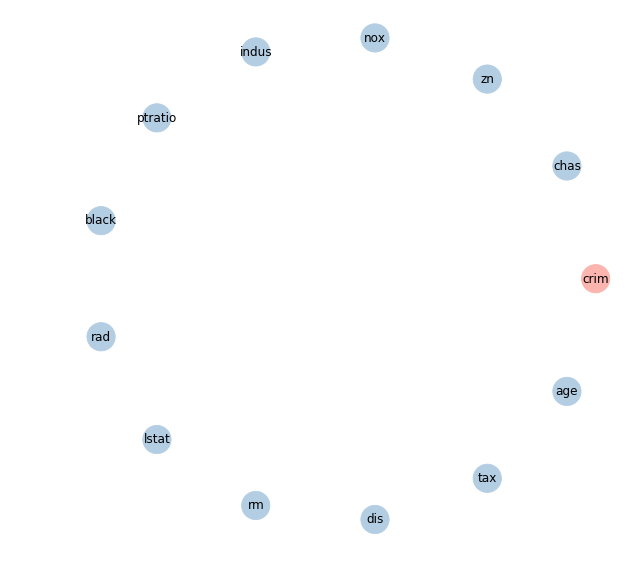

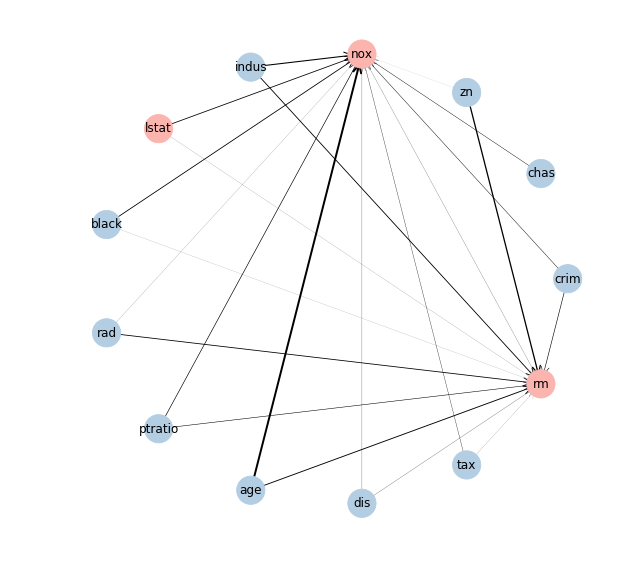

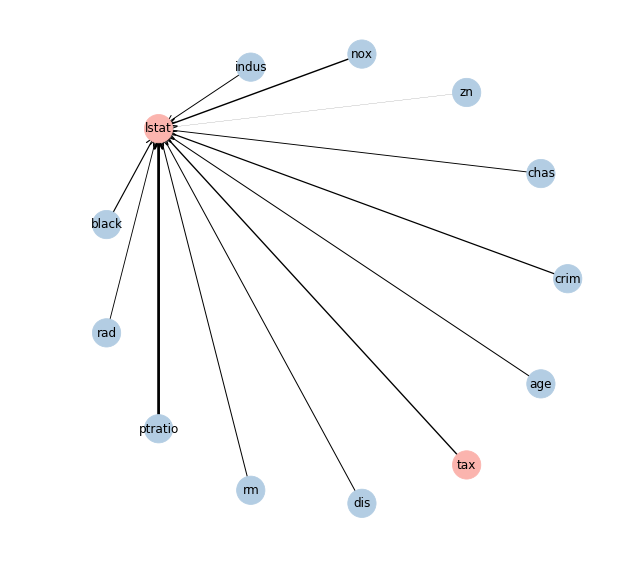

In [20]:
with sns.axes_style('white'):
    for num_fold in range(num_folds):
        train_model = 'models/{}/{}/'.format(data_name,num_fold)
        net, (fig, ax) = utils.visualize_feature_network(model_folder=train_model, w_scale=5)

<h4>5.4. Feature binning</h4>

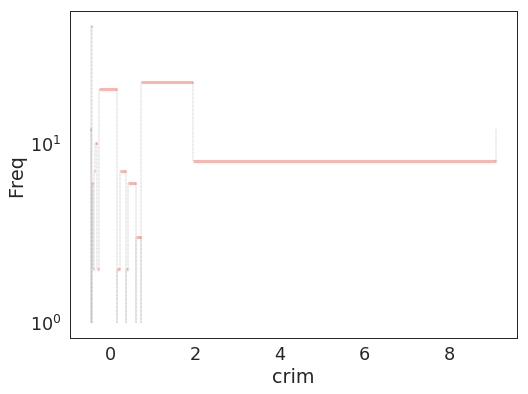

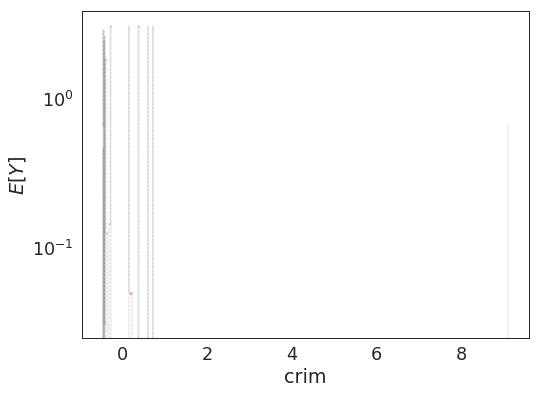

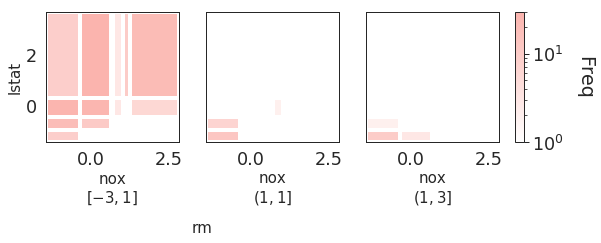

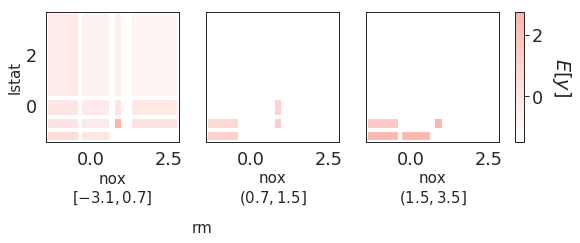

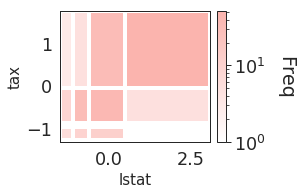

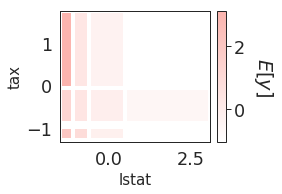

In [21]:
thres = 0
pink_color = '#FBB4AE'
my_cmap = mc.LinearSegmentedColormap.from_list('custom_pink', ['#ffffff', pink_color], N=256)

with sns.axes_style('white'):
    for num_fold in range(num_folds):
        train_model = 'models/{}/{}/'.format(data_name,num_fold)
        dim = int(dimensions[num_fold])

        splits_at_dim, N_dim, intensity_dim, pred_dim, chosen_f_dim = utils.visualize_s3d_model_reader(train_model, dim, thres)
        
        if dim == 1:
            # frequency
            fig, ax = utils.visualize_s3d_model_1d(splits_at_dim, N_dim,
                                            xlab=chosen_f_dim[0], ylab='Freq',
                                            xscale='linear',
                                            hlines_kwargs={'color': pink_color, 'linewidth': 3})
            
            # expected value
            fig, ax = utils.visualize_s3d_model_1d(splits_at_dim, intensity_dim, 
                                       xlab=chosen_f_dim[0], ylab=r'$E[Y]$',
                                       xscale='linear',
                                       hlines_kwargs={'color': pink_color, 'linewidth': 3})
        else:        
            # frequency
            fig, ax_arr, _ = utils.visualize_s3d_model(dim, splits_at_dim, my_cmap,
                                            N_dim, 'Freq', chosen_f_dim, 
                                            xscale='linear', yscale='linear',
                                            norm_func=mc.LogNorm,
                                            xbins_lab_decimal=0)

            # expected value
            fig, ax_arr, _ = utils.visualize_s3d_model(dim, splits_at_dim, my_cmap, 
                                            intensity_dim, '$E[y]$', chosen_f_dim, 
                                            xscale='linear', yscale='linear',
                                            xbins_lab_decimal=1)

<h4>5.5. X vs. Y</h4>

medv vs crim: -0.41
medv vs lstat: -0.74
medv vs ptratio: -0.48
medv vs rm: 0.69
medv vs indus: -0.47
medv vs tax: -0.45
medv vs nox: -0.41


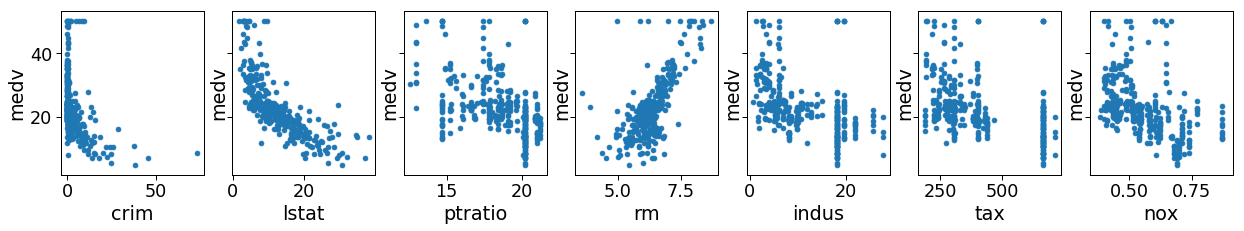

In [22]:
features = ['crim','lstat','ptratio','rm','indus','tax','nox']
w = len(features)*3
fig,axes = plt.subplots(1,len(features),figsize=(w,3), sharey=True)
for c,feature in enumerate(features):
    x = train_df[feature].values
    y = train_df.target.values
    cor = np.corrcoef(x, y)
    axes[c].scatter(x, y)
    print('{} vs {}: {}'.format(TARGET_COL, feature, round(cor[0,1],2)))
    _ = axes[c].set_xlabel(feature)
    _ = axes[c].set_ylabel(TARGET_COL)

<h4>5.6. Predictions on validation data</h4>

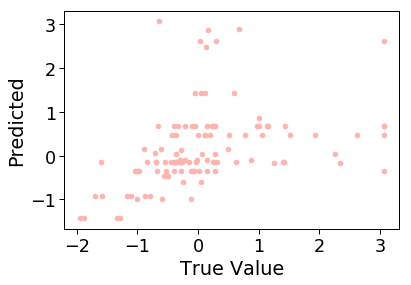

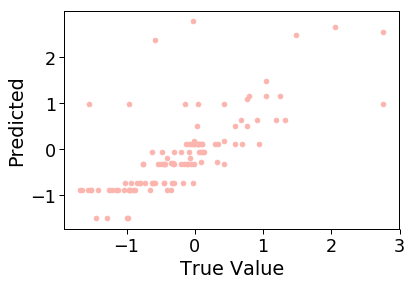

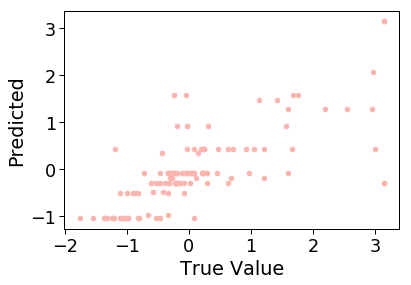

In [23]:
# performance prediction
for num_fold in range(num_folds):
    features = s3d.get_features(num_fold)
    num_features = len(features)

    y_score = pd.np.loadtxt(os.path.join(s3d.prediction_path, str(num_fold), 'predicted_expectations_MF_{}.csv'.format(int(num_features))))
    y_true = pd.read_csv( os.path.join(s3d.data_path, str(num_fold), 'test.csv')  )['target'].values

    if s3d.classification_flag:
        thres = s3d.calculate_disc_threshold(os.path.join(s3d.model_path,str(num_fold)), num_features)
        y_pred = (y_score >= thres).astype(int)

        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y_true, y_pred)
        np.set_printoptions(precision=2)

        # Plot non-normalized confusion matrix
        plt.figure()
        utils.plot_confusion_matrix(cnf_matrix, classes=classes, title='Confusion matrix, without normalization')
        plt.show()

        # Plot normalized confusion matrix
        plt.figure()
        utils.plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')
        plt.show()

    else:
        y_pred = y_score
        plt.scatter(y_true, y_pred, color=pink_color)
        plt.xlabel('True Value')
        plt.ylabel('Predicted')
        plt.show()
